In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
import albumentations as A
%matplotlib inline

In [2]:
DATA_PATH = '../Contest_Facial_Landmarks/data'
NUM_IMAGES_TO_SHOW = 9
NUM_COLS = 3
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [3]:
landmarks_path = os.path.join(DATA_PATH, 'train/landmarks.csv')
landmarks = pd.read_csv(landmarks_path, sep='\t', index_col='file_name')

In [4]:
from utils import NUM_PTS, CROP_SIZE, DATASET_MEAN, DATASET_STD


class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        self.size = np.asarray(size, dtype=float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample

In [5]:
class UpdatedHorizontalFlip(A.HorizontalFlip):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints = np.array(keypoints)
        keypoints[:, 0] = (params['cols'] - 1) - keypoints[:, 0]
        lm = keypoints
        nm = np.zeros_like(lm)
        nm[:64,:]     = lm[64:128,:]     # [  0, 63]  -> [ 64, 127]:  i --> i + 64
        nm[64:128,:]  = lm[:64,:]        # [ 64, 127] -> [  0, 63]:   i --> i - 64
        nm[128:273,:] = lm[272:127:-1,:] # [128, 272] -> [128, 272]:  i --> 400 - i
        nm[273:337,:] = lm[337:401,:]    # [273, 336] -> [337, 400]:  i --> i + 64
        nm[337:401,:] = lm[273:337,:]    # [337, 400] -> [273, 336]:  i --> i - 64
        nm[401:464,:] = lm[464:527,:]    # [401, 463] -> [464, 526]:  i --> i + 64
        nm[464:527,:] = lm[401:464,:]    # [464, 526] -> [401, 463]:  i --> i - 64
        nm[527:587,:] = lm[527:587,:]    # [527, 586] -> [527, 586]:  i --> i
        nm[587:714,:] = lm[714:841,:]    # [587, 713] -> [714, 840]:  i --> i + 127
        nm[714:841,:] = lm[587:714,:]    # [714, 840] -> [587, 713]:  i --> i - 127
        nm[841:873,:] = lm[872:840:-1,:] # [841, 872] -> [841, 872]:  i --> 1713 - i
        nm[873:905,:] = lm[904:872:-1,:] # [873, 904] -> [873, 904]:  i --> 1777 - i
        nm[905:937,:] = lm[936:904:-1,:] # [905, 936] -> [905, 936]:  i --> 1841 - i
        nm[937:969,:] = lm[968:936:-1,:] # [937, 968] -> [937, 968]:  i --> 1905 - i
        nm[969:971,:] = lm[970:968:-1,:] # [969, 970] -> [969, 970]:  i --> 1939 - i
        return nm

In [6]:
from torchvision import transforms


# train_transforms = A.Compose([
#         ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
#         CropCenter(CROP_SIZE),
#         # TransformByKeys(transforms.ToPILImage(), ("image",)),
#         # TransformByKeys(transforms.ToTensor(), ("image",)),
#         # TransformByKeys(transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD), ("image",)),
#     ])
image_augmentations = A.Compose([
    A.RandomBrightnessContrast(p=0.33),
    A.RandomGamma(p=0.33),
    A.CoarseDropout(p=0.3, min_holes=4, max_holes=10, min_width=10,
                    max_width=30, min_height=10, max_height=30),
    A.ToGray(p=0.1),
])
key_points_augmentations = A.Compose([
    UpdatedHorizontalFlip(p=0.5),
    A.Rotate([-20, 20], p=0.5),
],  keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(CROP_SIZE, p=1),
        A.CenterCrop(CROP_SIZE, CROP_SIZE, p=1),
    ],
    keypoint_params=A.KeypointParams(format='xy')
)
# transformed = transform(image=image, keypoints=keypoints)

In [7]:
def draw_landmarks(image, landmarks):
    if len(landmarks) > 971:
        landmarks = landmarks.numpy().astype(int).reshape((971, 2))
    elif isinstance(landmarks, list):
        landmarks = np.array(landmarks).astype(int)
    for idx, point in enumerate(landmarks.tolist()):
        cv2.circle(image, point, 1, (128, 0, 128), 1, -1)
    return image

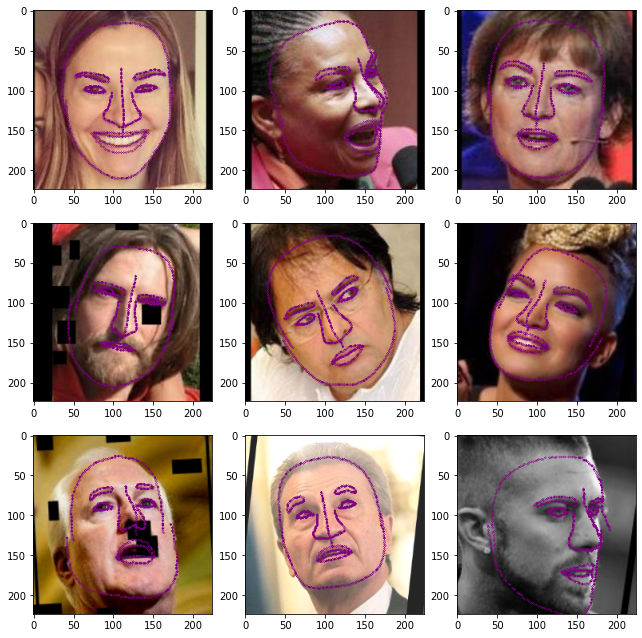

In [8]:
random_idxs = np.random.choice(landmarks.index, size=NUM_IMAGES_TO_SHOW)
plt.figure(figsize=(9, NUM_ROWS * 3))
for idx, name in enumerate(random_idxs, 1):
    image = cv2.imread(f"{DATA_PATH}/train/images/{name}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample = {
        "image": image,
        # "landmarks": torch.as_tensor(landmarks.loc[name].values.reshape(971, 2))
        "landmarks": landmarks.loc[name].values.reshape(971, 2)
    }
    sample['image'] = image_augmentations(image=sample['image'])['image']
    transformed = key_points_augmentations(image=sample['image'], keypoints=sample['landmarks'])
    sample['image'] = transformed['image']
    sample['landmarks'] = torch.Tensor(transformed['keypoints'])
    sample = train_transforms(image=sample['image'], keypoints=sample['landmarks'])
    image = draw_landmarks(sample['image'], sample['keypoints'])

    plt.subplot(NUM_ROWS, NUM_COLS, idx)
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [11]:
sample['keypoints']

[(118.7878787878788, 204.5757575757576),
 (117.0909090909091, 205.42424242424244),
 (115.39393939393939, 205.42424242424244),
 (112.84848484848486, 205.42424242424244),
 (111.15151515151516, 205.42424242424244),
 (108.60606060606061, 205.42424242424244),
 (106.9090909090909, 204.5757575757576),
 (105.21212121212122, 204.5757575757576),
 (103.51515151515152, 203.72727272727275),
 (100.96969696969697, 202.87878787878788),
 (99.27272727272728, 202.03030303030303),
 (97.57575757575758, 201.1818181818182),
 (95.87878787878788, 200.33333333333334),
 (94.18181818181819, 198.63636363636365),
 (93.33333333333334, 197.78787878787878),
 (91.63636363636364, 196.93939393939394),
 (89.93939393939394, 195.24242424242425),
 (88.24242424242425, 194.3939393939394),
 (87.39393939393939, 192.69696969696972),
 (85.6969696969697, 191.0),
 (84.0, 189.3030303030303),
 (83.15151515151516, 188.45454545454547),
 (81.45454545454545, 186.75757575757575),
 (79.75757575757576, 185.06060606060606),
 (78.9090909090909

In [95]:
|sample['landmarks'].shape

torch.Size([1942])

In [34]:
landmarks.iloc[0].values.reshape(971, 2).tolist()

[[162, 311],
 [159, 311],
 [156, 311],
 [152, 311],
 [149, 311],
 [146, 311],
 [143, 311],
 [140, 310],
 [137, 310],
 [134, 309],
 [130, 308],
 [127, 307],
 [124, 306],
 [121, 306],
 [118, 305],
 [115, 304],
 [112, 303],
 [109, 302],
 [107, 301],
 [104, 300],
 [101, 299],
 [98, 297],
 [95, 296],
 [92, 295],
 [89, 294],
 [86, 292],
 [83, 291],
 [79, 289],
 [76, 287],
 [74, 285],
 [71, 283],
 [68, 281],
 [66, 278],
 [63, 276],
 [61, 273],
 [59, 270],
 [57, 268],
 [55, 265],
 [53, 262],
 [52, 258],
 [51, 256],
 [50, 253],
 [49, 250],
 [48, 247],
 [47, 244],
 [46, 241],
 [45, 238],
 [45, 235],
 [44, 232],
 [44, 229],
 [43, 226],
 [43, 223],
 [43, 219],
 [42, 216],
 [42, 213],
 [42, 210],
 [42, 207],
 [41, 204],
 [41, 201],
 [41, 198],
 [41, 195],
 [41, 191],
 [41, 188],
 [41, 185],
 [165, 310],
 [167, 309],
 [169, 309],
 [172, 308],
 [174, 307],
 [176, 305],
 [178, 304],
 [180, 302],
 [181, 300],
 [183, 299],
 [184, 297],
 [185, 295],
 [186, 293],
 [188, 291],
 [189, 289],
 [190, 287],
 [1